# Comparación de eficacia
### Modelos de Clasificación

### Librerías necesarias

In [45]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

### Generación de datos a usar

In [46]:
# 1. Cargar los datos
df = pd.read_csv('../train.csv')

# 2. Crear la variable de respuesta categórica basada en los terciles del precio de venta
tercil_1 = df['SalePrice'].quantile(1/3)
tercil_2 = df['SalePrice'].quantile(2/3)

# Crear la categoría de precio
df['PriceCategory'] = pd.cut(
    df['SalePrice'], 
    bins=[0, tercil_1, tercil_2, float('inf')], 
    labels=['Económica', 'Intermedia', 'Cara']
)

print(f"Tercil 1 (33.33%): ${int(tercil_1):,}")
print(f"Tercil 2 (66.67%): ${int(tercil_2):,}")

# 3. Seleccionar las características para el modelo
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['PriceCategory']

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Codificar variables categóricas
encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    encoders[feature] = le

# 5. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Tercil 1 (33.33%): $139,699
Tercil 2 (66.67%): $190,000


### Creación de modelos
Copy - paste de los modelos creados anteriormente

#### Árbol de clasificación

In [47]:
dt_classifier = DecisionTreeClassifier(
    max_depth=7,             # Profundidad máxima del árbol
    min_samples_split=20,    # Mínimo de muestras para dividir un nodo
    min_samples_leaf=10,     # Mínimo de muestras en un nodo hoja
    random_state=42
)

start = time.time()
dt_classifier.fit(X_train, y_train)
tiempo_entrenamiento_dt = time.time() - start

# Evaluar el modelo
y_predDT = dt_classifier.predict(X_test)

#### Random Forest

In [48]:
rf_classifier = RandomForestClassifier(
    n_estimators=1000,        # Número de árboles en el bosque
    max_depth=7,             # Profundidad máxima de los árboles
    min_samples_split=20,    # Mínimo de muestras para dividir un nodo
    min_samples_leaf=10,     # Mínimo de muestras en un nodo hoja
    random_state=42,
    n_jobs=-1                # Usar todos los núcleos disponibles para mayor rendimiento
)

start = time.time()
rf_classifier.fit(X_train, y_train)
tiempo_entrenamiento_rf = time.time() - start

# Evaluar el modelo
y_predRF = rf_classifier.predict(X_test)

#### Naive Bayes

In [49]:
gaussian_nb = GaussianNB(var_smoothing = 1e-05)
start = time.time()
gaussian_nb.fit(X_train, y_train)
tiempo_entrenamiento_nb = time.time() - start

y_predNB = gaussian_nb.predict(X_test)

#### KNN model

In [50]:
knn_classifier = KNeighborsClassifier(
    algorithm= 'ball_tree', 
    n_neighbors= 12, 
    p= 1, 
    weights= 'distance')

start = time.time()
knn_classifier.fit(X_train, y_train)
tiempo_entrenamiento_knn = time.time() - start

y_predKNN = knn_classifier.predict(X_test)

### Comparación y análisis

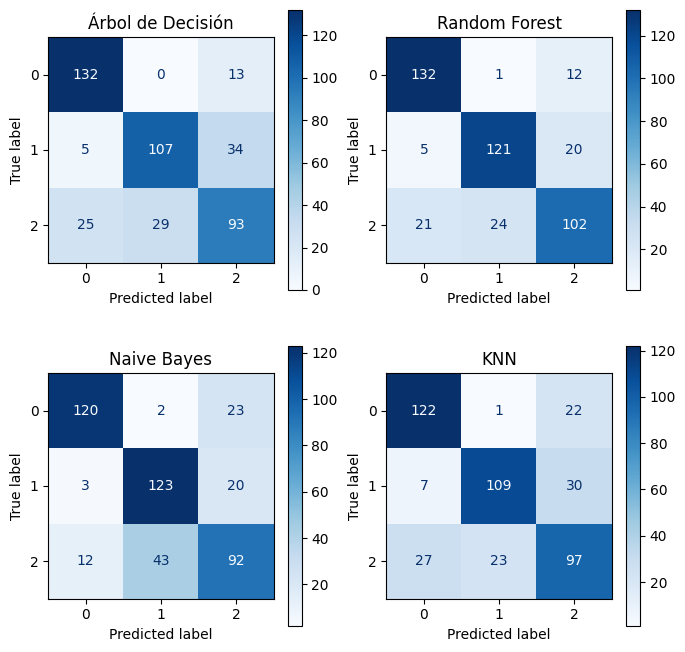

In [61]:
modelos = ["Árbol de Decisión", "Random Forest", "Naive Bayes", "KNN"]
# Graficar matriz de confusión para cada modelo
fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # Modifica el número de filas a 2

for ax, y_pred, title in zip(axes.flatten(), [y_predDT, y_predRF, y_predNB, y_predKNN], 
                             modelos):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap="Blues")
    ax.set_title(title)

plt.show()

Accuracy Árbol de Decisión: 0.7579908675799086
Accuracy Random Forest: 0.8105022831050228
Accuracy Naive Bayes: 0.7648401826484018
Accuracy KNN: 0.7488584474885844


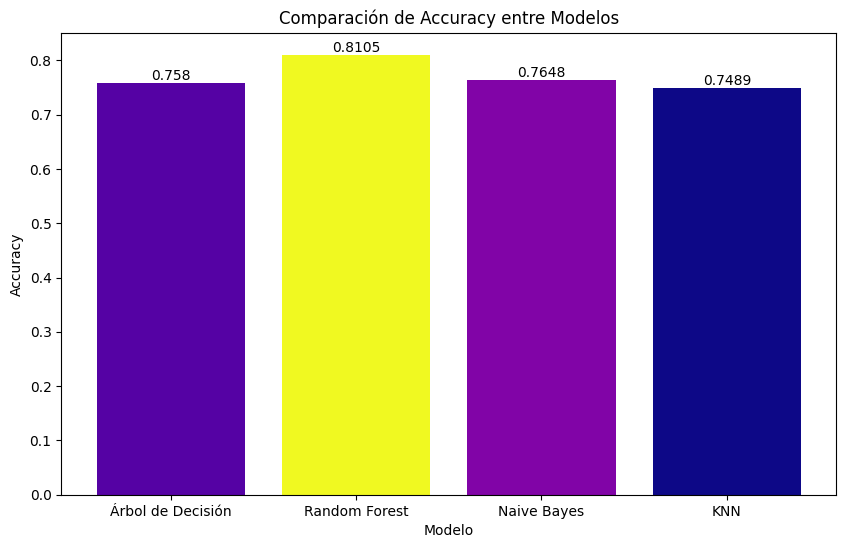

In [63]:
print("Accuracy Árbol de Decisión:", accuracy_score(y_test, y_predDT))
print("Accuracy Random Forest:", accuracy_score(y_test, y_predRF))
print("Accuracy Naive Bayes:", accuracy_score(y_test, y_predNB))
print("Accuracy KNN:", accuracy_score(y_test, y_predKNN))

accuracy_values = [
    accuracy_score(y_test, y_predDT),
    accuracy_score(y_test, y_predRF),
    accuracy_score(y_test, y_predNB),
    accuracy_score(y_test, y_predKNN),
]

# Normalizar los valores de R²
norm = Normalize(vmin=min(accuracy_values), vmax=max(accuracy_values))

cmap = colormaps['plasma']

# Asignar colores a las barras
colors = [cmap(norm(value)) for value in accuracy_values]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, accuracy_values, color=colors)
plt.title('Comparación de Accuracy entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')

# Agregar etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
    
plt.show()

Tiempo de entrenamiento (Árbol de Decisión): 0.012003421783447266
Tiempo de entrenamiento (Random Forest): 2.072594404220581
Tiempo de entrenamiento (Naive Bayes): 0.006024360656738281
Tiempo de entrenamiento (KNN): 0.004994869232177734


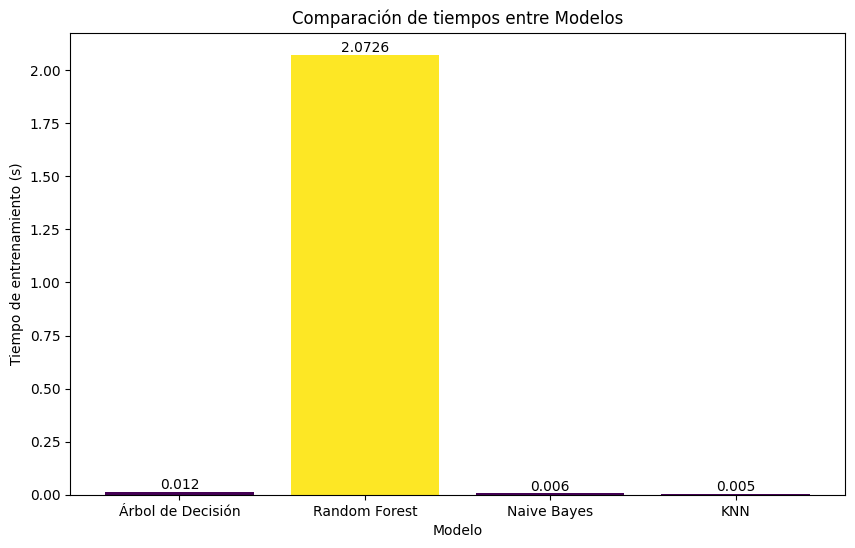

In [65]:
# Comparar tiempos de ejecución
time_values = [
    tiempo_entrenamiento_dt,
    tiempo_entrenamiento_rf,
    tiempo_entrenamiento_nb,
    tiempo_entrenamiento_knn
]

print("Tiempo de entrenamiento (Árbol de Decisión):", tiempo_entrenamiento_dt)
print("Tiempo de entrenamiento (Random Forest):", tiempo_entrenamiento_rf)
print("Tiempo de entrenamiento (Naive Bayes):", tiempo_entrenamiento_nb)
print("Tiempo de entrenamiento (KNN):", tiempo_entrenamiento_knn)

# Normalizar los valores
norm = Normalize(vmin=min(time_values), vmax=max(time_values))

cmap = colormaps['viridis']

# Asignar colores a las barras
colors = [cmap(norm(value)) for value in time_values]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, time_values, color=colors)
plt.title('Comparación de tiempos entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Tiempo de entrenamiento (s)')

# Agregar etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

In [53]:
print("Reporte de clasificación para Árbol de Decisión:\n", classification_report(y_test, y_predDT))
print("Reporte de clasificación para Random Forest:\n", classification_report(y_test, y_predRF))
print("Reporte de clasificación para Naive Bayes:\n", classification_report(y_test, y_predNB))
print("Reporte de clasificación para KNN:\n", classification_report(y_test, y_predKNN))

Reporte de clasificación para Árbol de Decisión:
               precision    recall  f1-score   support

        Cara       0.81      0.91      0.86       145
   Económica       0.79      0.73      0.76       146
  Intermedia       0.66      0.63      0.65       147

    accuracy                           0.76       438
   macro avg       0.76      0.76      0.76       438
weighted avg       0.75      0.76      0.76       438

Reporte de clasificación para Random Forest:
               precision    recall  f1-score   support

        Cara       0.84      0.91      0.87       145
   Económica       0.83      0.83      0.83       146
  Intermedia       0.76      0.69      0.73       147

    accuracy                           0.81       438
   macro avg       0.81      0.81      0.81       438
weighted avg       0.81      0.81      0.81       438

Reporte de clasificación para Naive Bayes:
               precision    recall  f1-score   support

        Cara       0.89      0.83      0.86